In [1]:
import os
import gc
import re
import math
import pickle
import joblib
import warnings

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

from sklearn.model_selection import KFold, GroupKFold

from catboost import CatBoost, Pool

warnings.simplefilter("ignore")
pd.set_option("display.max_columns", None)

from IPython.core.display import display, HTML

display(HTML("<style>.container { width:96% !important; }</style>"))  # デフォルトは75%

In [2]:
import random as rn
import numpy as np


def set_seed(seed=0):
    os.environ["PYTHONHASHSEED"] = str(seed)

    rn.seed(seed)
    np.random.seed(seed)

In [3]:
from sklearn.metrics import mean_squared_log_error


def score(y, y_pred):
    RMSLE = np.sqrt(np.mean(((np.log(y + 1) - np.log(y_pred + 1)) ** 2)))
    # RMSLE = mean_squared_log_error(y, y_pred) ** 0.5
    return RMSLE

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt


def display_importances(
    importance_df, png_path=f"feature_importance.png",
):
    """feature_importance plot"""
    # importance_df.sort_values(by="importance", ascending=False).to_csv(
    #    f"feature_importance.csv"
    # )
    cols = (
        importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:100]
        .index
    )
    best_features = importance_df.loc[importance_df.feature.isin(cols)]
    plt.figure(figsize=(8, 15))
    sns.barplot(
        x="importance",
        y="feature",
        data=best_features.sort_values(by="importance", ascending=False),
    )
    plt.title(f"CatBoost (avg over folds)   {png_path}")
    plt.tight_layout()
    plt.savefig(png_path)

In [5]:
import category_encoders as ce


def count_encoder(
    X_train, Y_train, X_val, Y_val, target_col: str, cat_features=None, features=None
):
    """
    Count_Encoding: カテゴリ列をカウント値に変換する特徴量エンジニアリング（要はgroupby().size()の集計列追加のこと）
    ※カウント数が同じカテゴリは同じようなデータ傾向になる可能性がある
    https://www.kaggle.com/matleonard/categorical-encodings
    """
    X_train = pd.DataFrame(X_train, columns=features)
    Y_train = pd.DataFrame(Y_train, columns=[target_col])
    X_val = pd.DataFrame(X_val, columns=features)
    Y_val = pd.DataFrame(Y_val, columns=[target_col])

    train_df = X_train.join(Y_train)
    valid_df = X_val.join(Y_val)

    count_enc = ce.CountEncoder(cols=cat_features)

    # trainだけでfitすること(validationやtest含めるとリークする)
    count_enc.fit(train_df[cat_features])
    train_encoded = train_df.join(
        count_enc.transform(train_df[cat_features]).add_suffix("_count")
    )
    valid_encoded = valid_df.join(
        count_enc.transform(valid_df[cat_features]).add_suffix("_count")
    )

    features = train_encoded.drop(target_col, axis=1).columns.to_list()

    # return train_encoded, valid_encoded
    return (
        train_encoded.drop(target_col, axis=1),
        valid_encoded.drop(target_col, axis=1),
        features,
    )


def target_encoder(
    X_train, Y_train, X_val, Y_val, target_col: str, cat_features=None, features=None
):
    """
    Target_Encoding: カテゴリ列を目的変数の平均値に変換する特徴量エンジニアリング
    https://www.kaggle.com/matleonard/categorical-encodings
    """
    X_train = pd.DataFrame(X_train, columns=features)
    Y_train = pd.DataFrame(Y_train, columns=[target_col])
    X_val = pd.DataFrame(X_val, columns=features)
    Y_val = pd.DataFrame(Y_val, columns=[target_col])

    train_df = X_train.join(Y_train)
    valid_df = X_val.join(Y_val)

    target_enc = ce.TargetEncoder(cols=cat_features)

    # trainだけでfitすること(validationやtest含めるとリークする)
    target_enc.fit(train_df[cat_features], train_df[target_col])

    train_encoded = train_df.join(
        target_enc.transform(train_df[cat_features]).add_suffix("_target")
    )
    valid_encoded = valid_df.join(
        target_enc.transform(valid_df[cat_features]).add_suffix("_target")
    )

    features = train_encoded.drop(target_col, axis=1).columns.to_list()

    # return train_encoded, valid_encoded
    return (
        train_encoded.drop(target_col, axis=1),
        valid_encoded.drop(target_col, axis=1),
        features,
    )


def catboost_encoder(
    X_train, Y_train, X_val, Y_val, target_col: str, cat_features=None, features=None
):
    """
    CatBoost_Encoding: カテゴリ列を目的変数の1行前の行からのみに変換する特徴量エンジニアリング
    CatBoost使ったターゲットエンコーディング
    https://www.kaggle.com/matleonard/categorical-encodings
    """
    X_train = pd.DataFrame(X_train, columns=features)
    Y_train = pd.DataFrame(Y_train, columns=[target_col])
    X_val = pd.DataFrame(X_val, columns=features)
    Y_val = pd.DataFrame(Y_val, columns=[target_col])

    train_df = X_train.join(Y_train)
    valid_df = X_val.join(Y_val)

    cb_enc = ce.CatBoostEncoder(cols=cat_features, random_state=7)

    # trainだけでfitすること(validationやtest含めるとリークする)
    cb_enc.fit(train_df[cat_features], train_df[target_col])

    train_encoded = train_df.join(
        cb_enc.transform(train_df[cat_features]).add_suffix("_cb")
    )
    valid_encoded = valid_df.join(
        cb_enc.transform(valid_df[cat_features]).add_suffix("_cb")
    )

    features = train_encoded.drop(target_col, axis=1).columns.to_list()

    # return train_encoded, valid_encoded
    return (
        train_encoded.drop(target_col, axis=1),
        valid_encoded.drop(target_col, axis=1),
        features,
    )

# Data load

In [6]:
import pandas as pd

DATADIR = r"C:\Users\81908\jupyter_notebook\poetry_work\tfgpu\atmaCup_#8\data\atmacup08-dataset"
train = pd.read_csv(f"{DATADIR}/train.csv")
test = pd.read_csv(f"{DATADIR}/test.csv")
df = pd.concat([train, test], axis=0)

# 前処理

In [7]:
import numpy as np

# tbd(確認中)を欠損にする
df["User_Score"] = df["User_Score"].replace("tbd", np.nan)

In [8]:
# -1で補完
cate_cols = [
    "Name",
    "Platform",
    "Year_of_Release",
    "Genre",
    "Publisher",
    "Developer",
    "Rating",
]
for col in cate_cols:
    df[col].fillna(-1, inplace=True)

In [9]:
def impute_null_add_flag_col(
    df, strategy="mean", cols_with_missing=None, fill_value=None
):
    """欠損値を補間して欠損フラグ列を追加する
    fill_value はstrategy="constant"の時のみ有効になる補間する定数
    """
    from sklearn.impute import SimpleImputer

    df_plus = df.copy()

    for col in cols_with_missing:
        # 欠損フラグ列を追加
        df_plus[col + "_was_missing"] = df[col].isnull()
        df_plus[col + "_was_missing"] = df_plus[col + "_was_missing"].astype(int)
        # 欠損値を平均値で補間
        my_imputer = SimpleImputer(strategy=strategy, fill_value=fill_value)
        df_plus[col] = my_imputer.fit_transform(df[[col]])

    return df_plus


df = impute_null_add_flag_col(
    df, strategy="most_frequent", cols_with_missing=["User_Score"]
)  # 最頻値で補間

df = impute_null_add_flag_col(
    df, cols_with_missing=["Critic_Score", "Critic_Count", "User_Count",],
)  # 平均値で補間（数値列のみ）

In [10]:
# User_Scoreを数値列にする
df["User_Score"] = df["User_Score"].astype("float")

# User_Scoreを文字列にする
df["Year_of_Release"] = df["Year_of_Release"].astype("str")

In [11]:
# ラベルエンコディング
cate_cols = df.select_dtypes(include=["object", "category", "bool"]).columns.to_list()
for col in cate_cols:
    df[col], uni = pd.factorize(df[col])

In [12]:
train = df.iloc[: train.shape[0]]
test = df.iloc[train.shape[0] :].reset_index(drop=True)

# 目的変数
sales_cols = [
    "NA_Sales",
    "EU_Sales",
    "JP_Sales",
    "Other_Sales",
    "Global_Sales",
]

train_drop_sales = train.drop(sales_cols, axis=1)
test = test.drop(sales_cols, axis=1)

# FE

In [13]:
df = pd.concat([train_drop_sales, test], axis=0)

In [14]:
# 行単位で統計量とる
def add_num_row_agg(df_all, agg_num_cols):
    """行単位の統計量列追加
    agg_num_cols は数値列だけでないとエラー"""
    import warnings

    warnings.filterwarnings("ignore")

    df = df_all[agg_num_cols]
    cols = df.columns.to_list()
    cols = map(str, cols)  # 文字列にする
    col_name = "_".join(cols)

    df_all[f"row_{col_name}_sum"] = df.sum(axis=1)
    df_all[f"row_{col_name}_mean"] = df.mean(axis=1)
    df_all[f"row_{col_name}_std"] = df.std(axis=1)
    # df_all[f"row_{col_name}_skew"] = df.skew(axis=1)  # 歪度 Nan になるからやめる

    return df_all


df = add_num_row_agg(df, ["Critic_Score", "User_Score"])
df = add_num_row_agg(df, ["Critic_Count", "User_Count"])

In [15]:
import numpy as np
import pandas as pd


# A列でグループして集計したB列は意味がありそうと仮説たててから統計値列作ること
# 目的変数をキーにして集計するとリークしたターゲットエンコーディングになるため説明変数同士で行うこと
def grouping(df, cols, agg_dict, prefix=""):
    """特定のカラムについてgroup化された特徴量の作成を行う
    Args:
        df (pd.DataFrame): 特徴量作成のもととなるdataframe
        cols (str or list): group by処理のkeyとなるカラム (listで複数指定可能)
        agg_dict (dict): 特徴量作成を行いたいカラム/集計方法を指定するdictionary
        prefix (str): 集約後のカラムに付与するprefix name

    Returns:
        df (pd.DataFrame): 特定のカラムについてgroup化された特徴量群
    """
    group_df = df.groupby(cols).agg(agg_dict)
    group_df.columns = [prefix + c[0] + "_" + c[1] for c in list(group_df.columns)]
    group_df.reset_index(inplace=True)

    return group_df


class AggUtil:
    ############## カテゴリ列 vs. 数値列について ##############
    @staticmethod
    def percentile(n):
        """パーセンタイル"""

        def percentile_(x):
            return np.percentile(x, n)

        percentile_.__name__ = "percentile_%s" % n
        return percentile_

    @staticmethod
    def diff_percentile(n1, n2):
        """パーセンタイルの差"""

        def diff_percentile_(x):
            p1 = np.percentile(x, n1)
            p2 = np.percentile(x, n2)
            return p1 - p2

        diff_percentile_.__name__ = f"diff_percentile_{n1}-{n2}"
        return diff_percentile_

    @staticmethod
    def ratio_percentile(n1, n2):
        """パーセンタイルの比"""

        def ratio_percentile_(x):
            p1 = np.percentile(x, n1)
            p2 = np.percentile(x, n2)
            return p1 / p2

        ratio_percentile_.__name__ = f"ratio_percentile_{n1}-{n2}"
        return ratio_percentile_

    @staticmethod
    def mean_var():
        """平均分散"""

        def mean_var_(x):
            x = x.dropna()
            return np.std(x) / np.mean(x)

        mean_var_.__name__ = f"mean_var"
        return mean_var_

    @staticmethod
    def diff_mean():
        """平均との差の中央値(aggは集計値でないとエラーになるから中央値をとる)"""

        def diff_mean_(x):
            x = x.dropna()
            return np.median(x - np.mean(x))

        diff_mean_.__name__ = f"diff_mean"
        return diff_mean_

    @staticmethod
    def ratio_mean():
        """平均との比の中央値(aggは一意な値でないとエラーになるから中央値をとる)"""

        def ratio_mean_(x):
            x = x.dropna()
            return np.median(x / np.mean(x))

        ratio_mean_.__name__ = f"ratio_mean"
        return ratio_mean_

    @staticmethod
    def hl_ratio():
        """平均より高いサンプル数と低いサンプル数の比率"""

        def hl_ratio_(x):
            x = x.dropna()
            n_high = x[x >= np.mean(x)].shape[0]
            n_low = x[x < np.mean(x)].shape[0]
            if n_low == 0:
                return 1.0
            else:
                return n_high / n_low

        hl_ratio_.__name__ = f"hl_ratio"
        return hl_ratio_

    @staticmethod
    def ratio_range():
        """最大/最小"""

        def ratio_range_(x):
            x = x.dropna()
            if np.min(x) == 0:
                return 1.0
            else:
                return np.max(x) / np.min(x)

        ratio_range_.__name__ = f"ratio_range"
        return ratio_range_

    @staticmethod
    def beyond1std():
        """1stdを超える比率"""

        def beyond1std_(x):
            x = x.dropna()
            return x[np.abs(x) > np.abs(np.std(x))].shape[0] / x.shape[0]

        beyond1std_.__name__ = "beyond1std"
        return beyond1std_

    @staticmethod
    def zscore():
        """Zスコアの中央値(aggは一意な値でないとエラーになるから中央値をとる)"""

        def zscore_(x):
            x = x.dropna()
            return np.median((x - np.mean(x)) / np.std(x))

        zscore_.__name__ = "zscore"
        return zscore_

    ######################################################

    ############## カテゴリ列 vs. カテゴリ列について ##############
    @staticmethod
    def freq_entropy():
        """出現頻度のエントロピー"""
        from scipy.stats import entropy

        def freq_entropy_(x):
            return entropy(x.value_counts().values)

        freq_entropy_.__name__ = "freq_entropy"
        return freq_entropy_

    @staticmethod
    def freq1name():
        """最も頻繁に出現するカテゴリの数"""

        def freq1name_(x):
            return x.value_counts().sort_values(ascending=False)[0]

        freq1name_.__name__ = "freq1name"
        return freq1name_

    @staticmethod
    def freq1ratio():
        """最も頻繁に出現するカテゴリ/グループの数"""

        def freq1ratio_(x):
            frq = x.value_counts().sort_values(ascending=False)
            return frq[0] / frq.shape[0]

        freq1ratio_.__name__ = "freq1ratio"
        return freq1ratio_

    #########################################################


# 集計する数値列指定
value_agg = {
    "User_Count": [
        "max",
        "min",
        "mean",
        "std",  # 標準偏差
        "skew",  # 歪度
        pd.DataFrame.kurt,  # 尖度
    ],
    "Critic_Count": [
        "max",
        "min",
        "mean",
        "std",  # 標準偏差
        "skew",  # 歪度
        pd.DataFrame.kurt,  # 尖度
    ],
    "User_Score": [
        "max",
        "min",
        "mean",
        "std",  # 標準偏差
        "skew",  # 歪度
        pd.DataFrame.kurt,  # 尖度
    ],
    "Critic_Score": [
        "max",
        "min",
        "mean",
        "std",  # 標準偏差
        "skew",  # 歪度
        pd.DataFrame.kurt,  # 尖度
    ],
}
# グループ化するカテゴリ列でループ
for key in ["Platform", "Genre", "Publisher", "Developer", "Rating"]:
    feature_df = grouping(df, key, value_agg, prefix=key + "_")
    df = pd.merge(df, feature_df, how="left", on=key)

In [16]:
df["Critic_Score_*_Critic_Count"] = df["Critic_Score"] * df["Critic_Count"]
df["User_Score_*_User_Count"] = df["User_Score"] * df["User_Count"]
df["Critic_Score_*_User_Score"] = df["Critic_Score"] * df["User_Score"]
df["Critic_Count_*_User_Count"] = df["Critic_Count"] * df["User_Count"]
df["Critic_Count_+_User_Count"] = df["Critic_Count"] + df["User_Count"]
df["Critic_Count_-_User_Count"] = df["Critic_Count"] - df["User_Count"]
df["Critic_Count_/_all_Count"] = df["Critic_Count"] / df["Critic_Count_+_User_Count"]

In [17]:
# KMeansでクラスタリングした列追加

from sklearn.cluster import KMeans


def fe_cluster(df, kind, features, n_clusters=100, SEED=42, is_dummies=False):
    df_ = df[features].copy()
    kmeans_cells = KMeans(n_clusters=n_clusters, random_state=SEED).fit(df_)
    df[f"clusters_{kind}"] = kmeans_cells.predict(df_.values)
    df = pd.get_dummies(df, columns=[f"clusters_{kind}"]) if is_dummies else df

    return df


df = fe_cluster(
    df,
    kind="cate_cols",
    features=["Name", "Genre", "Publisher", "Developer", "Rating"],
    n_clusters=3000,
)
df = fe_cluster(
    df,
    kind="Score_Count",
    features=["Critic_Score", "User_Score", "Critic_Count", "User_Count"],
    n_clusters=300,
)

In [18]:
train_drop_sales = df.iloc[: train.shape[0]]
test = df.iloc[train.shape[0] :].reset_index(drop=True)

pd.concat([train_drop_sales, train[sales_cols]], axis=1).to_csv("train_fe.csv", index=False)
test.to_csv("test_fe.csv", index=False)

In [19]:
train_drop_sales

,Name,Platform,Year_of_Release,Genre,Publisher,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,User_Score_was_missing,Critic_Score_was_missing,Critic_Count_was_missing,User_Count_was_missing,row_Critic_Score_User_Score_sum,row_Critic_Score_User_Score_mean,row_Critic_Score_User_Score_std,row_Critic_Count_User_Count_sum,row_Critic_Count_User_Count_mean,row_Critic_Count_User_Count_std,Platform_User_Count_max,Platform_User_Count_min,Platform_User_Count_mean,Platform_User_Count_std,Platform_User_Count_skew,Platform_User_Count_kurt,Platform_Critic_Count_max,Platform_Critic_Count_min,Platform_Critic_Count_mean,Platform_Critic_Count_std,Platform_Critic_Count_skew,Platform_Critic_Count_kurt,Platform_User_Score_max,Platform_User_Score_min,Platform_User_Score_mean,Platform_User_Score_std,Platform_User_Score_skew,Platform_User_Score_kurt,Platform_Critic_Score_max,Platform_Critic_Score_min,Platform_Critic_Score_mean,Platform_Critic_Score_std,Platform_Critic_Score_skew,Platform_Critic_Score_kurt,Genre_User_Count_max,Genre_User_Count_min,Genre_User_Count_mean,Genre_User_Count_std,Genre_User_Count_skew,Genre_User_Count_kurt,Genre_Critic_Count_max,Genre_Critic_Count_min,Genre_Critic_Count_mean,Genre_Critic_Count_std,Genre_Critic_Count_skew,Genre_Critic_Count_kurt,Genre_User_Score_max,Genre_User_Score_min,Genre_User_Score_mean,Genre_User_Score_std,Genre_User_Score_skew,Genre_User_Score_kurt,Genre_Critic_Score_max,Genre_Critic_Score_min,Genre_Critic_Score_mean,Genre_Critic_Score_std,Genre_Critic_Score_skew,Genre_Critic_Score_kurt,Publisher_User_Count_max,Publisher_User_Count_min,Publisher_User_Count_mean,Publisher_User_Count_std,Publisher_User_Count_skew,Publisher_User_Count_kurt,Publisher_Critic_Count_max,Publisher_Critic_Count_min,Publisher_Critic_Count_mean,Publisher_Critic_Count_std,Publisher_Critic_Count_skew,Publisher_Critic_Count_kurt,Publisher_User_Score_max,Publisher_User_Score_min,Publisher_User_Score_mean,Publisher_User_Score_std,Publisher_User_Score_skew,Publisher_User_Score_kurt,Publisher_Critic_Score_max,Publisher_Critic_Score_min,Publisher_Critic_Score_mean,Publisher_Critic_Score_std,Publisher_Critic_Score_skew,Publisher_Critic_Score_kurt,Developer_User_Count_max,Developer_User_Count_min,Developer_User_Count_mean,Developer_User_Count_std,Developer_User_Count_skew,Developer_User_Count_kurt,Developer_Critic_Count_max,Developer_Critic_Count_min,Developer_Critic_Count_mean,Developer_Critic_Count_std,Developer_Critic_Count_skew,Developer_Critic_Count_kurt,Developer_User_Score_max,Developer_User_Score_min,Developer_User_Score_mean,Developer_User_Score_std,Developer_User_Score_skew,Developer_User_Score_kurt,Developer_Critic_Score_max,Developer_Critic_Score_min,Developer_Critic_Score_mean,Developer_Critic_Score_std,Developer_Critic_Score_skew,Developer_Critic_Score_kurt,Rating_User_Count_max,Rating_User_Count_min,Rating_User_Count_mean,Rating_User_Count_std,Rating_User_Count_skew,Rating_User_Count_kurt,Rating_Critic_Count_max,Rating_Critic_Count_min,Rating_Critic_Count_mean,Rating_Critic_Count_std,Rating_Critic_Count_skew,Rating_Critic_Count_kurt,Rating_User_Score_max,Rating_User_Score_min,Rating_User_Score_mean,Rating_User_Score_std,Rating_User_Score_skew,Rating_User_Score_kurt,Rating_Critic_Score_max,Rating_Critic_Score_min,Rating_Critic_Score_mean,Rating_Critic_Score_std,Rating_Critic_Score_skew,Rating_Critic_Score_kurt,Critic_Score_*_Critic_Count,User_Score_*_User_Count,Critic_Score_*_User_Score,Critic_Count_*_User_Count,Critic_Count_+_User_Count,Critic_Count_-_User_Count,Critic_Count_/_all_Count,clusters_cate_cols,clusters_Score_Count
0,0,0,0,0,0,74.000000,17.000000,7.9,22.000000,0,0,0,0,0,0,81.900000,40.950000,46.739758,39.000000,19.500000,3.535534,2147.000000,4.000000,115.942220,134.680370,8.680930,112.286301,87.000000,4.000000,24.094851,11.556586,1.281734,5.078568,9.3,0.2,7.351439,1.247140,-2.681698,8.297436,97.000000,19.000000,66.244882,10.359427,-1.509346,3.764847,8003.0,4.0,176.706842,399.969165,8.692938,104.66

In [20]:
test

,Name,Platform,Year_of_Release,Genre,Publisher,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,User_Score_was_missing,Critic_Score_was_missing,Critic_Count_was_missing,User_Count_was_missing,row_Critic_Score_User_Score_sum,row_Critic_Score_User_Score_mean,row_Critic_Score_User_Score_std,row_Critic_Count_User_Count_sum,row_Critic_Count_User_Count_mean,row_Critic_Count_User_Count_std,Platform_User_Count_max,Platform_User_Count_min,Platform_User_Count_mean,Platform_User_Count_std,Platform_User_Count_skew,Platform_User_Count_kurt,Platform_Critic_Count_max,Platform_Critic_Count_min,Platform_Critic_Count_mean,Platform_Critic_Count_std,Platform_Critic_Count_skew,Platform_Critic_Count_kurt,Platform_User_Score_max,Platform_User_Score_min,Platform_User_Score_mean,Platform_User_Score_std,Platform_User_Score_skew,Platform_User_Score_kurt,Platform_Critic_Score_max,Platform_Critic_Score_min,Platform_Critic_Score_mean,Platform_Critic_Score_std,Platform_Critic_Score_skew,Platform_Critic_Score_kurt,Genre_User_Count_max,Genre_User_Count_min,Genre_User_Count_mean,Genre_User_Count_std,Genre_User_Count_skew,Genre_User_Count_kurt,Genre_Critic_Count_max,Genre_Critic_Count_min,Genre_Critic_Count_mean,Genre_Critic_Count_std,Genre_Critic_Count_skew,Genre_Critic_Count_kurt,Genre_User_Score_max,Genre_User_Score_min,Genre_User_Score_mean,Genre_User_Score_std,Genre_User_Score_skew,Genre_User_Score_kurt,Genre_Critic_Score_max,Genre_Critic_Score_min,Genre_Critic_Score_mean,Genre_Critic_Score_std,Genre_Critic_Score_skew,Genre_Critic_Score_kurt,Publisher_User_Count_max,Publisher_User_Count_min,Publisher_User_Count_mean,Publisher_User_Count_std,Publisher_User_Count_skew,Publisher_User_Count_kurt,Publisher_Critic_Count_max,Publisher_Critic_Count_min,Publisher_Critic_Count_mean,Publisher_Critic_Count_std,Publisher_Critic_Count_skew,Publisher_Critic_Count_kurt,Publisher_User_Score_max,Publisher_User_Score_min,Publisher_User_Score_mean,Publisher_User_Score_std,Publisher_User_Score_skew,Publisher_User_Score_kurt,Publisher_Critic_Score_max,Publisher_Critic_Score_min,Publisher_Critic_Score_mean,Publisher_Critic_Score_std,Publisher_Critic_Score_skew,Publisher_Critic_Score_kurt,Developer_User_Count_max,Developer_User_Count_min,Developer_User_Count_mean,Developer_User_Count_std,Developer_User_Count_skew,Developer_User_Count_kurt,Developer_Critic_Count_max,Developer_Critic_Count_min,Developer_Critic_Count_mean,Developer_Critic_Count_std,Developer_Critic_Count_skew,Developer_Critic_Count_kurt,Developer_User_Score_max,Developer_User_Score_min,Developer_User_Score_mean,Developer_User_Score_std,Developer_User_Score_skew,Developer_User_Score_kurt,Developer_Critic_Score_max,Developer_Critic_Score_min,Developer_Critic_Score_mean,Developer_Critic_Score_std,Developer_Critic_Score_skew,Developer_Critic_Score_kurt,Rating_User_Count_max,Rating_User_Count_min,Rating_User_Count_mean,Rating_User_Count_std,Rating_User_Count_skew,Rating_User_Count_kurt,Rating_Critic_Count_max,Rating_Critic_Count_min,Rating_Critic_Count_mean,Rating_Critic_Count_std,Rating_Critic_Count_skew,Rating_Critic_Count_kurt,Rating_User_Score_max,Rating_User_Score_min,Rating_User_Score_mean,Rating_User_Score_std,Rating_User_Score_skew,Rating_User_Score_kurt,Rating_Critic_Score_max,Rating_Critic_Score_min,Rating_Critic_Score_mean,Rating_Critic_Score_std,Rating_Critic_Score_skew,Rating_Critic_Score_kurt,Critic_Score_*_Critic_Count,User_Score_*_User_Count,Critic_Score_*_User_Score,Critic_Count_*_User_Count,Critic_Count_+_User_Count,Critic_Count_-_User_Count,Critic_Count_/_all_Count,clusters_cate_cols,clusters_Score_Count
0,6231,14,0,0,295,84.000000,23.000000,8.0,19.000000,1012,2,0,0,0,0,92.000000,46.000000,53.740115,42.000000,21.000000,2.828427,1283.0,4.0,64.110095,90.445403,5.811620,70.390878,91.000000,4.0,26.369807,14.117421,1.243040,2.408514,9.3,0.5,7.587015,1.280184,-2.167418,5.901917,97.0,19.0,69.752185,13.191776,-0.808820,0.939315,8003.0,4.0,176.706842,399.969165,8.692938,104.669797,106.0,4.0,27.1

# params

In [21]:
n_seeds = 1
n_splits = 5
shuffle = True

params = {
    "loss_function": "RMSE",
    "eval_metric": "RMSE",
#    "depth": 12,
#    "random_strength": 0.1,
#    "l2_leaf_reg": 10,
#    "subsample": 0.9,
    "num_boost_round": 20000,
    "task_type": "GPU",
}
verbose_eval = 100
early_stopping_rounds = verbose_eval

# catbostに渡すカテゴリ型のカラム
cat_features = cate_cols  # + ["clusters_cate_cols", "clusters_Score_Count"]

#DEBUG = True
DEBUG = False
if DEBUG:
    n_seeds = 1
    n_splits = 2
    params["learning_rate"] = 0.1
    params["num_boost_round"] = 100
    verbose_eval = 50
    early_stopping_rounds = verbose_eval

In [22]:
features = test.columns.to_list()

global_target_col = "Global_Sales"
target_cols = [
    "NA_Sales",
    "EU_Sales",
    "JP_Sales",
    "Other_Sales",
]

X = train_drop_sales[features].copy()
Y = train[target_cols].copy()
Y_global = train[global_target_col].copy()

train_size, n_features = X.shape
# group = X["Name"].copy()
group = X[
    "Publisher"
].copy()  # https://www.guruguru.science/competitions/13/discussions/42fc473d-4450-4cfc-b924-0a5d61fd0ca7/
_, n_classes = Y.shape

# catboost

In [23]:
%%time

f_importance = {col: None for col in Y.columns}
Y_pred = np.zeros((train_size, n_classes))
Y_pred = pd.DataFrame(Y_pred, columns=Y.columns, index=Y.index)

for i in tqdm(range(n_seeds)):
    set_seed(seed=i)
    params["random_state"] = i

    # cv = KFold(n_splits=n_splits, random_state=i, shuffle=shuffle)
    # cv_split = cv.split(X, Y)
    cv = GroupKFold(n_splits=n_splits)
    cv_split = cv.split(X, Y, group)

    for j, (trn_idx, val_idx) in enumerate(cv_split):
        print(f"\n------------ fold:{j} ------------")

        X_train, X_val = X.iloc[trn_idx], X.iloc[val_idx]
        Y_train_targets, Y_val_targets = Y.iloc[trn_idx], Y.iloc[val_idx]

        for tar, tar_col in enumerate(Y.columns):
            print(f"\n------------ target:{tar_col} ------------")
            Y_train, Y_val = (
                Y_train_targets.values[:, tar],
                Y_val_targets.values[:, tar],
            )

            X_train_enc, X_val_enc, features_enc = (
                X_train.copy(),
                X_val.copy(),
                features.copy(),
            )
            # count_encoder はやめとく。存在しないNameやPublisherなnanaになるので
            # X_train_enc, X_val_enc, features_enc = count_encoder(X_train_enc, Y_train, X_val_enc, Y_val, target_col=tar_col, cat_features=cate_cols, features=features_enc)
            # X_train_enc, X_val_enc, features_enc = target_encoder(X_train_enc, Y_train, X_val_enc, Y_val, target_col=tar_col, cat_features=cate_cols, features=features_enc,)
            # X_train_enc, X_val_enc, features_enc = catboost_encoder(X_train_enc, Y_train, X_val_enc, Y_val, target_col=tar_col, cat_features=cate_cols, features=features_enc)

            # display(X_val_enc.head())

            #train_pool = Pool(X_train, Y_train, cat_features=cat_features)
            #eval_pool = Pool(X_val, Y_val, cat_features=cat_features)
            train_pool = Pool(X_train_enc, label=Y_train, cat_features=cat_features)
            eval_pool = Pool(X_val_enc, label=Y_val, cat_features=cat_features)

            model = CatBoost(params)
            model.fit(train_pool, eval_set=eval_pool, 
                      use_best_model=True, 
                      early_stopping_rounds=early_stopping_rounds,
                      verbose_eval=verbose_eval,
                     )
            
            # Y_pred[tar_col][val_idx] += model.predict(X_val) / n_seeds
            Y_pred[tar_col][val_idx] += model.predict(X_val_enc) / n_seeds

            imp = np.array(model.get_feature_importance()) / (n_seeds * n_splits)
            if f_importance[tar_col] is None:
                f_importance[tar_col] = imp
            else:
                f_importance[tar_col] += imp

            joblib.dump(model, f"model_seed_{i}_fold_{j}_{tar_col}.jlb", compress=True)

for col in Y.columns:
    idx = Y_pred[Y_pred[col] < 0].index
    Y_pred[col][idx] = 0.0

with open("Y_pred.pkl", "wb") as f:
    pickle.dump(Y_pred, f)



------------ fold:0 ------------

------------ target:NA_Sales ------------
Learning rate set to 0.020305
0:	learn: 115.2631309	test: 34.7273406	best: 34.7273406 (0)	total: 86.3ms	remaining: 28m 46s
100:	learn: 107.7536806	test: 32.7236325	best: 32.7236325 (100)	total: 7.56s	remaining: 24m 50s
200:	learn: 103.3631789	test: 32.4359728	best: 32.4279404 (195)	total: 15s	remaining: 24m 42s
300:	learn: 101.0566398	test: 32.4601269	best: 32.3623557 (244)	total: 22.8s	remaining: 24m 53s
bestTest = 32.36235575
bestIteration = 244
Shrink model to first 245 iterations.

------------ target:EU_Sales ------------
Learning rate set to 0.020305
0:	learn: 67.1067529	test: 22.0631248	best: 22.0631248 (0)	total: 101ms	remaining: 33m 31s
100:	learn: 59.9227807	test: 20.5965840	best: 20.5965840 (100)	total: 7.6s	remaining: 24m 57s
200:	learn: 57.1192415	test: 20.2180140	best: 20.2151906 (198)	total: 15.3s	remaining: 25m 9s
300:	learn: 55.0055695	test: 20.1859969	best: 20.1859969 (300)	total: 22.7s	remai

0:	learn: 113.4474447	test: 53.2436678	best: 53.2436678 (0)	total: 81.9ms	remaining: 27m 18s
100:	learn: 106.2498136	test: 47.3867859	best: 47.3867859 (100)	total: 7.55s	remaining: 24m 47s
200:	learn: 101.4937221	test: 44.9511081	best: 44.9511081 (200)	total: 16.1s	remaining: 26m 26s
300:	learn: 99.0717105	test: 43.7600655	best: 43.7600655 (300)	total: 24s	remaining: 26m 10s
400:	learn: 97.1541829	test: 43.3009715	best: 43.3009715 (400)	total: 36.8s	remaining: 29m 56s
500:	learn: 95.7900132	test: 43.0250741	best: 43.0111310 (480)	total: 46.5s	remaining: 30m 10s
600:	learn: 94.6191630	test: 42.7996159	best: 42.7996159 (600)	total: 55.2s	remaining: 29m 40s
700:	learn: 93.3228476	test: 42.6406535	best: 42.6264338 (684)	total: 1m 4s	remaining: 29m 24s
800:	learn: 92.4559284	test: 42.4505376	best: 42.4505376 (800)	total: 1m 13s	remaining: 29m 16s
900:	learn: 91.7438649	test: 42.2682678	best: 42.2629312 (899)	total: 1m 21s	remaining: 28m 53s
1000:	learn: 90.6936037	test: 42.1719786	best: 42.

0:	learn: 111.9896612	test: 64.1820654	best: 64.1820654 (0)	total: 43.5ms	remaining: 14m 29s
100:	learn: 100.6102492	test: 63.1417004	best: 62.4020933 (50)	total: 4.69s	remaining: 15m 23s
bestTest = 62.40209327
bestIteration = 50
Shrink model to first 51 iterations.

------------ target:EU_Sales ------------
Learning rate set to 0.020305
0:	learn: 64.4149044	test: 43.3498064	best: 43.3498064 (0)	total: 43.1ms	remaining: 14m 21s
100:	learn: 53.1629480	test: 47.4898884	best: 43.0388969 (8)	total: 4.65s	remaining: 15m 15s
bestTest = 43.03889693
bestIteration = 8
Shrink model to first 9 iterations.

------------ target:JP_Sales ------------
Learning rate set to 0.020305
0:	learn: 44.1376198	test: 25.6231887	best: 25.6231887 (0)	total: 39ms	remaining: 13m
100:	learn: 39.3688753	test: 26.5490186	best: 25.5963435 (1)	total: 4.52s	remaining: 14m 50s
bestTest = 25.5963435
bestIteration = 1
Shrink model to first 2 iterations.

------------ target:Other_Sales ------------
Learning rate set to 0.0

In [24]:
score(Y, Y_pred)

NA_Sales       1.781123
EU_Sales       1.638545
JP_Sales       1.620719
Other_Sales    1.040431
dtype: float64

In [25]:
score(Y_global, Y_pred.sum(axis=1))

1.4235004717952646

,NA_Sales,EU_Sales,JP_Sales,Other_Sales
Name,3.104097,1.990796,3.087569,4.296454
Platform,3.141313,1.226170,6.398301,9.149286
Year_of_Release,3.667781,0.711813,3.575206,0.847295
Genre,0.751883,0.201827,2.488628,0.352031
Publisher,5.537213,2.408734,10.651976,1.284591
...,...,...,...,...
Critic_Count_+_User_Count,0.032113,0.201859,0.086544,0.235500
Critic_Count_-_User_Count,0.626567,0.520607,0.228408,0.459585
Critic_Count_/_all_Count,0.038095,0.073223,0.099642,0.075839
clusters_cate_cols,0.121927,0.060124,0.170926,0.024943


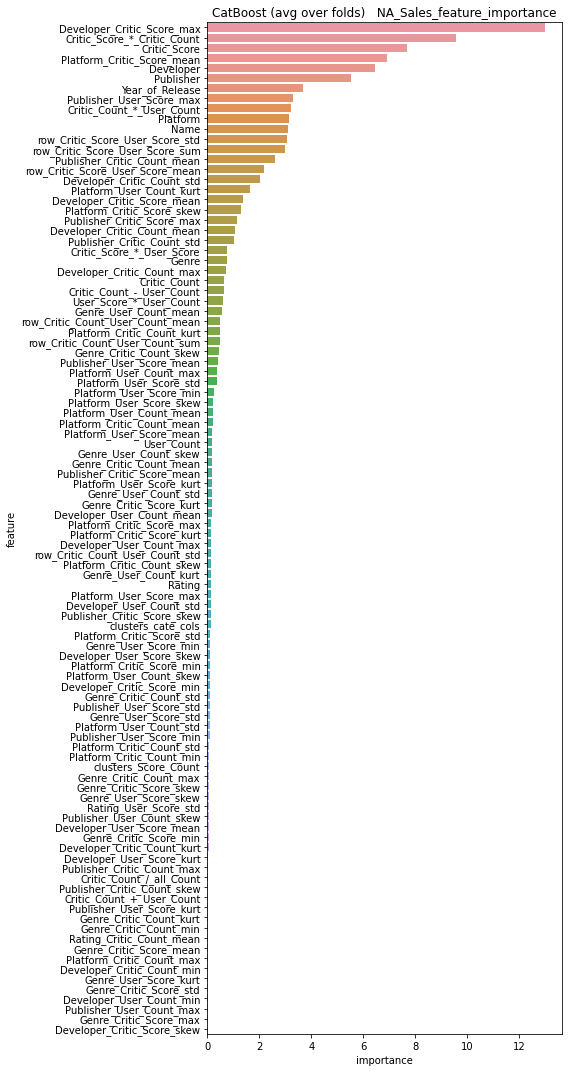

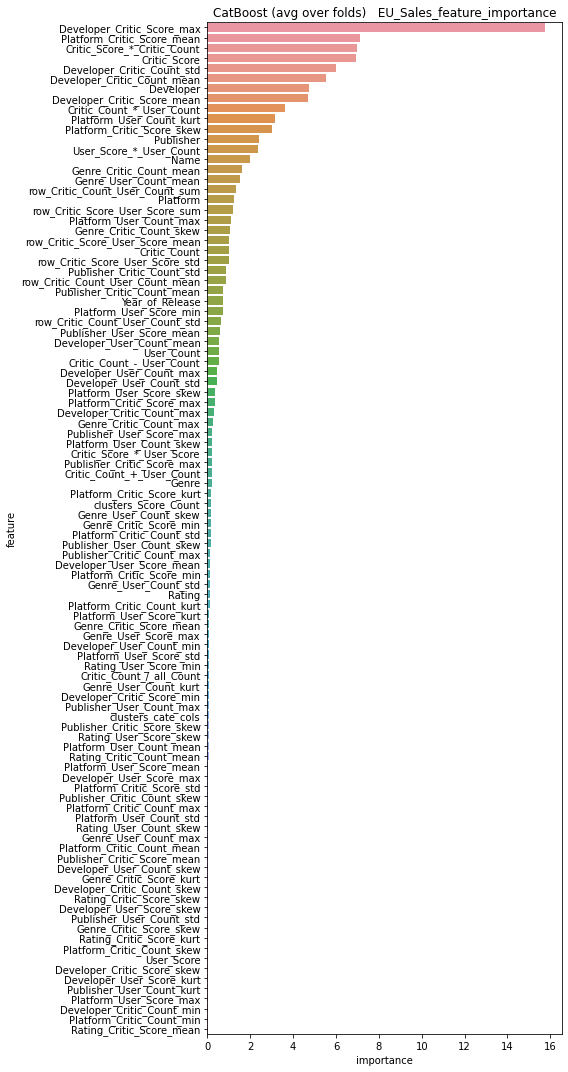

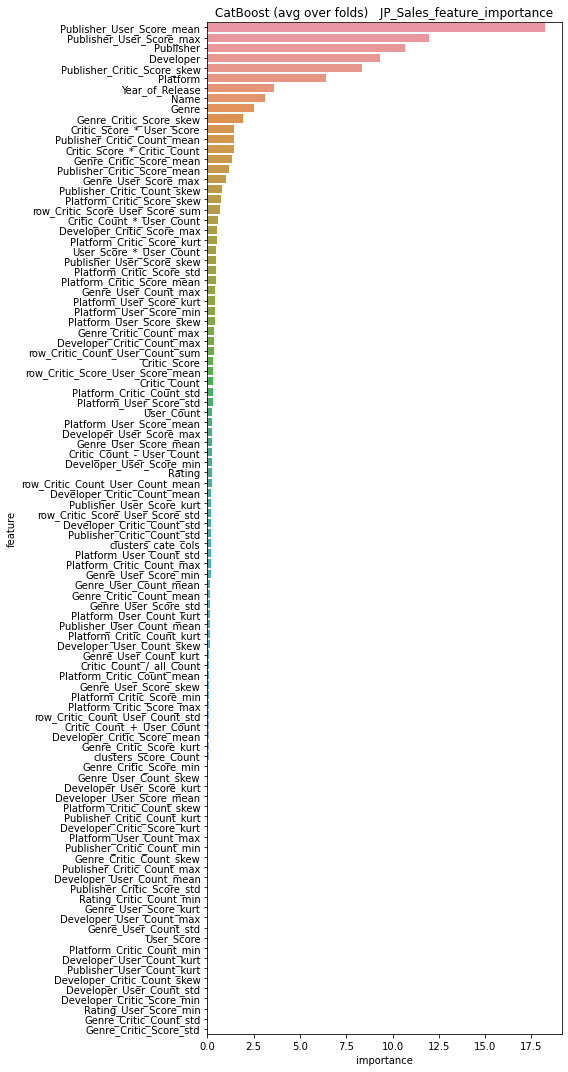

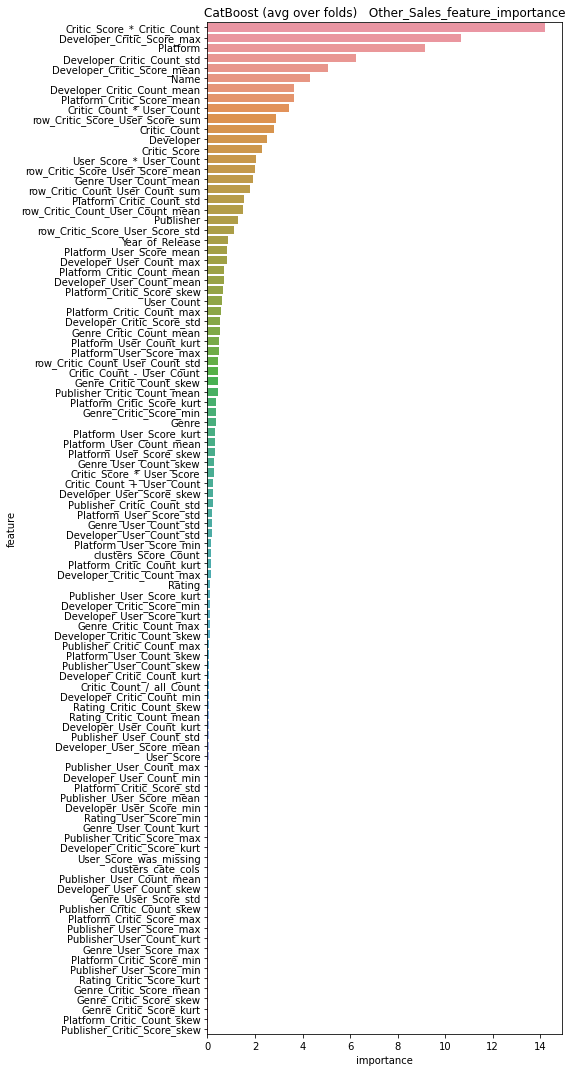

In [26]:
def _importance(features, n_features):
    df_f_imps = np.zeros((n_features, len(f_importance)))
    df_f_imps = pd.DataFrame(df_f_imps, columns=Y.columns, index=model.feature_names_)

    for _, tar_col in enumerate(Y.columns):
        df_importance = pd.DataFrame(
            {"feature": model.feature_names_, "importance": f_importance[tar_col]}
        )
        display_importances(df_importance, png_path=f"{tar_col}_feature_importance")

        df_f_imps[tar_col] = f_importance[tar_col]

    df_f_imps.to_csv("feature_importance.csv")
    return df_f_imps


# _importance(features, n_features)
df_f_imps = _importance(features_enc, len(features_enc))
df_f_imps

# oof

In [27]:
# path = r"Y_pred.pkl"
# with open(path, "rb") as f:
#    Y_pred = pickle.load(f)
# Y_pred

# predict test

In [28]:
X_test = test.copy()
Y_test_pred = pd.Series(np.zeros((test.shape[0])))

for i in range(n_seeds):
    for j in range(n_splits):
        for tar_col in Y.columns:
            model_path = f"model_seed_{i}_fold_{j}_{tar_col}.jlb"
            model = joblib.load(model_path)

            X_enc, X_test_enc, features_enc = X.copy(), X_test.copy(), features.copy()
            # count_encoder はやめとく。存在しないNameやPublisherなnanaになるので
            # X_enc, X_test_enc, features_enc = count_encoder(X_enc, Y[tar_col], X_test_enc, Y_test_pred, target_col=tar_col, cat_features=cate_cols, features=features_enc)
            # X_enc, X_test_enc, features_enc = target_encoder(X_enc, Y[tar_col], X_test_enc, Y_test_pred, target_col=tar_col, cat_features=cate_cols, features=features_enc,)
            # X_enc, X_test_enc, features_enc = catboost_encoder(X_enc, Y[tar_col], X_test_enc, Y_test_pred, target_col=tar_col, cat_features=cate_cols, features=features_enc)

            # display(X_test_enc.head())

            # _y_pred = model.predict(X_test) / (n_seeds * n_splits)
            _y_pred = model.predict(X_test_enc) / (n_seeds * n_splits)
            _y_pred[_y_pred < 0] = 0.0

            Y_test_pred += _y_pred

print(Y_test_pred.shape)

submission = pd.read_csv(f"{DATADIR}/atmaCup8_sample-submission.csv")
submission["Global_Sales"] = Y_test_pred
submission.to_csv("submission.csv", index=False)
submission

(8360,)


,Global_Sales
0,32.487793
1,87.351863
2,51.403509
3,43.588214
4,38.607124
...,...
8355,32.603790
8356,33.026465
8357,19.910643
8358,22.155415


# psude_label

In [29]:
# 疑似ラベル作成
X_test = test.copy()
Y_test_pred = np.zeros((test.shape[0], n_classes))
Y_test_pred = pd.DataFrame(Y_test_pred, columns=target_cols, index=test.index)

for i in range(n_seeds):
    for j in range(n_splits):
        for tar_col in Y.columns:
            model_path = f"model_seed_{i}_fold_{j}_{tar_col}.jlb"
            model = joblib.load(model_path)

            X_enc, X_test_enc, features_enc = X.copy(), X_test.copy(), features.copy()
            # count_encoder はやめとく。存在しないNameやPublisherなnanaになるので
            # X_enc, X_test_enc, features_enc = count_encoder(X_enc, Y[tar_col], X_test_enc, Y_test_pred, target_col=tar_col, cat_features=cate_cols, features=features_enc)
            # X_enc, X_test_enc, features_enc = target_encoder(X_enc, Y[tar_col], X_test_enc, Y_test_pred, target_col=tar_col, cat_features=cate_cols, features=features_enc,)
            # X_enc, X_test_enc, features_enc = catboost_encoder(X_enc, Y[tar_col], X_test_enc, Y_test_pred, target_col=tar_col, cat_features=cate_cols, features=features_enc)

            # display(X_test_enc.head())

            # _y_pred = model.predict(X_test) / (n_seeds * n_splits)
            _y_pred = model.predict(X_test_enc) / (n_seeds * n_splits)
            _y_pred[_y_pred < 0] = 0.0

            Y_test_pred[tar_col] += _y_pred
Y_test_pred

,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,18.154464,8.847970,3.776505,1.708854
1,46.646262,15.669858,19.687562,5.348181
2,30.635850,11.396535,5.889610,3.481514
3,24.944491,10.635341,5.095531,2.912850
4,20.480425,9.331617,5.149904,3.645178
...,...,...,...,...
8355,15.027589,8.807248,6.881019,1.887933
8356,15.639211,9.400401,5.671290,2.315563
8357,9.125591,6.056710,3.576862,1.151480
8358,9.660931,6.982208,4.374598,1.137679


In [30]:
# 疑似ラベル連結
X_test = test.copy()

X = pd.concat([X, X_test], axis=0).reset_index(drop=True)
Y = pd.concat([Y, Y_test_pred], axis=0).reset_index(drop=True)

train_size, n_features = X.shape
# group = X["Name"].copy()
group = X[
    "Publisher"
].copy()  # https://www.guruguru.science/competitions/13/discussions/42fc473d-4450-4cfc-b924-0a5d61fd0ca7/
_, n_classes = Y.shape

print(X.shape, Y.shape)

(16719, 150) (16719, 4)


In [31]:
# importance 上位100位までの特徴量だけにする
features_imp = sorted(
    pd.DataFrame(df_f_imps.sum(axis=1))
    .sort_values(by=0, ascending=False)[:120]
    .index.to_list()
)

features_imp

['Critic_Count',
 'Critic_Count_*_User_Count',
 'Critic_Count_+_User_Count',
 'Critic_Count_-_User_Count',
 'Critic_Count_/_all_Count',
 'Critic_Score',
 'Critic_Score_*_Critic_Count',
 'Critic_Score_*_User_Score',
 'Developer',
 'Developer_Critic_Count_kurt',
 'Developer_Critic_Count_max',
 'Developer_Critic_Count_mean',
 'Developer_Critic_Count_min',
 'Developer_Critic_Count_skew',
 'Developer_Critic_Count_std',
 'Developer_Critic_Score_kurt',
 'Developer_Critic_Score_max',
 'Developer_Critic_Score_mean',
 'Developer_Critic_Score_min',
 'Developer_Critic_Score_std',
 'Developer_User_Count_kurt',
 'Developer_User_Count_max',
 'Developer_User_Count_mean',
 'Developer_User_Count_min',
 'Developer_User_Count_skew',
 'Developer_User_Count_std',
 'Developer_User_Score_kurt',
 'Developer_User_Score_max',
 'Developer_User_Score_mean',
 'Developer_User_Score_min',
 'Developer_User_Score_skew',
 'Genre',
 'Genre_Critic_Count_kurt',
 'Genre_Critic_Count_max',
 'Genre_Critic_Count_mean',
 'Genre

In [32]:
%%time

# 疑似ラベル付けて再学習

Y_pred = np.zeros((train_size, n_classes))
Y_pred = pd.DataFrame(Y_pred, columns=Y.columns, index=Y.index)

for i in tqdm(range(n_seeds)):
    set_seed(seed=i)
    params["random_state"] = i

    # cv = KFold(n_splits=n_splits, random_state=i, shuffle=shuffle)
    # cv_split = cv.split(X, Y)
    cv = GroupKFold(n_splits=n_splits)
    cv_split = cv.split(X, Y, group)

    for j, (trn_idx, val_idx) in enumerate(cv_split):
        print(f"\n------------ fold:{j} ------------")

        X_train, X_val = X.iloc[trn_idx], X.iloc[val_idx]
        Y_train_targets, Y_val_targets = Y.iloc[trn_idx], Y.iloc[val_idx]

        for tar, tar_col in enumerate(Y.columns):
            print(f"\n------------ target:{tar_col} ------------")
            Y_train, Y_val = (
                Y_train_targets.values[:, tar],
                Y_val_targets.values[:, tar],
            )

            X_train_enc, X_val_enc, features_enc = (
                X_train.copy(),
                X_val.copy(),
                features.copy(),
            )
            # count_encoder はやめとく。存在しないNameやPublisherなnanaになるので
            # X_train_enc, X_val_enc, features_enc = count_encoder(X_train_enc, Y_train, X_val_enc, Y_val, target_col=tar_col, cat_features=cate_cols, features=features_enc)
            # X_train_enc, X_val_enc, features_enc = target_encoder(X_train_enc, Y_train, X_val_enc, Y_val, target_col=tar_col, cat_features=cate_cols, features=features_enc,)
            # X_train_enc, X_val_enc, features_enc = catboost_encoder(X_train_enc, Y_train, X_val_enc, Y_val, target_col=tar_col, cat_features=cate_cols, features=features_enc)

            # importance 上位100位までの特徴量だけにする
            X_train_enc, X_val_enc = X_train_enc[features_imp], X_val_enc[features_imp]

            # display(X_val_enc.head())

            #train_pool = Pool(X_train, Y_train, cat_features=cat_features)
            #eval_pool = Pool(X_val, Y_val, cat_features=cat_features)
            train_pool = Pool(X_train_enc, label=Y_train, cat_features=cat_features)
            eval_pool = Pool(X_val_enc, label=Y_val, cat_features=cat_features)

            model = CatBoost(params)
            model.fit(train_pool, eval_set=eval_pool, 
                      use_best_model=True, 
                      early_stopping_rounds=early_stopping_rounds,
                      verbose_eval=verbose_eval,
                     )
            
            # Y_pred[tar_col][val_idx] += model.predict(X_val) / n_seeds
            Y_pred[tar_col][val_idx] += model.predict(X_val_enc) / n_seeds
            
            joblib.dump(model, f"model_seed_{i}_fold_{j}_{tar_col}.jlb", compress=True)

for col in Y.columns:
    idx = Y_pred[Y_pred[col] < 0].index
    Y_pred[col][idx] = 0.0
    
with open("Y_pred_psude_label.pkl", "wb") as f:
    pickle.dump(Y_pred.iloc[: train.shape[0]], f)
    


------------ fold:0 ------------

------------ target:NA_Sales ------------
Learning rate set to 0.021036
0:	learn: 77.0729457	test: 63.2800508	best: 63.2800508 (0)	total: 57.9ms	remaining: 19m 18s
100:	learn: 73.4340470	test: 58.7288341	best: 58.7288341 (100)	total: 4.67s	remaining: 15m 20s
200:	learn: 71.2564262	test: 56.3926235	best: 56.3926235 (200)	total: 9.47s	remaining: 15m 33s
300:	learn: 70.1452783	test: 55.4468553	best: 55.4468553 (300)	total: 14s	remaining: 15m 13s
400:	learn: 69.6189253	test: 54.2979718	best: 54.2979718 (400)	total: 18.5s	remaining: 15m 4s
500:	learn: 68.7334214	test: 53.5223760	best: 53.5222894 (498)	total: 23s	remaining: 14m 54s
600:	learn: 68.2458886	test: 52.9677951	best: 52.9677951 (600)	total: 27.5s	remaining: 14m 49s
700:	learn: 67.8264173	test: 52.4327719	best: 52.4299173 (699)	total: 32.1s	remaining: 14m 43s
800:	learn: 67.4106223	test: 52.1923659	best: 52.1923573 (799)	total: 36.7s	remaining: 14m 40s
900:	learn: 66.8788342	test: 51.9765256	best: 

bestTest = 4.986668503
bestIteration = 358
Shrink model to first 359 iterations.

------------ fold:2 ------------

------------ target:NA_Sales ------------
Learning rate set to 0.021036
0:	learn: 81.2518945	test: 37.4150933	best: 37.4150933 (0)	total: 51.8ms	remaining: 17m 16s
100:	learn: 77.8639849	test: 34.1212963	best: 34.1212963 (100)	total: 4.74s	remaining: 15m 33s
200:	learn: 75.9993822	test: 32.3788873	best: 32.3788873 (200)	total: 9.37s	remaining: 15m 23s
300:	learn: 74.8162809	test: 31.4872739	best: 31.4872133 (299)	total: 13.7s	remaining: 14m 59s
400:	learn: 73.8350412	test: 30.8621869	best: 30.8621869 (400)	total: 18.3s	remaining: 14m 52s
500:	learn: 73.3351594	test: 30.5829770	best: 30.5829513 (499)	total: 22.6s	remaining: 14m 41s
600:	learn: 72.5792689	test: 30.1965192	best: 30.1938897 (596)	total: 27.2s	remaining: 14m 36s
700:	learn: 72.1628273	test: 30.0057149	best: 30.0055642 (677)	total: 31.6s	remaining: 14m 31s
800:	learn: 71.5866975	test: 29.8384005	best: 29.838337

300:	learn: 33.9173630	test: 143.2758907	best: 143.2757989 (294)	total: 13.2s	remaining: 14m 20s
400:	learn: 32.9860531	test: 143.0555067	best: 143.0555067 (400)	total: 17s	remaining: 13m 52s
500:	learn: 32.4336366	test: 142.9320697	best: 142.9223950 (468)	total: 21.8s	remaining: 14m 7s
600:	learn: 31.8932226	test: 142.7730742	best: 142.7720018 (598)	total: 26.6s	remaining: 14m 17s
700:	learn: 31.5129073	test: 142.4859600	best: 142.4859600 (700)	total: 31.2s	remaining: 14m 19s
800:	learn: 31.0801087	test: 142.2702126	best: 142.2688253 (798)	total: 36.1s	remaining: 14m 24s
900:	learn: 30.6806621	test: 142.0720048	best: 142.0700346 (885)	total: 40.8s	remaining: 14m 25s
1000:	learn: 30.3751300	test: 141.9964030	best: 141.9888381 (986)	total: 45.6s	remaining: 14m 25s
1100:	learn: 30.1027549	test: 141.8822883	best: 141.8822714 (1099)	total: 50.3s	remaining: 14m 22s
1200:	learn: 29.8390023	test: 141.7847533	best: 141.7822729 (1198)	total: 54.9s	remaining: 14m 19s
1300:	learn: 29.6632388	test

400:	learn: 14.9714975	test: 55.1819413	best: 55.1816216 (396)	total: 18.1s	remaining: 14m 44s
500:	learn: 14.7490244	test: 54.9405453	best: 54.9405453 (500)	total: 22.9s	remaining: 14m 51s
600:	learn: 14.5305357	test: 54.7480910	best: 54.7480910 (600)	total: 27.7s	remaining: 14m 53s
700:	learn: 14.3765320	test: 54.5333811	best: 54.5333811 (700)	total: 32.4s	remaining: 14m 51s
800:	learn: 14.2441836	test: 54.3951985	best: 54.3951985 (800)	total: 37.3s	remaining: 14m 54s
900:	learn: 14.1256279	test: 54.2445756	best: 54.2441015 (886)	total: 42.3s	remaining: 14m 56s
1000:	learn: 14.0180078	test: 54.0952001	best: 54.0850993 (994)	total: 47.1s	remaining: 14m 53s
1100:	learn: 13.9263007	test: 54.0387897	best: 54.0387897 (1100)	total: 51.9s	remaining: 14m 50s
1200:	learn: 13.8440047	test: 53.9918560	best: 53.9806529 (1177)	total: 56.9s	remaining: 14m 50s
1300:	learn: 13.7464334	test: 53.9094774	best: 53.9094774 (1300)	total: 1m 1s	remaining: 14m 49s
1400:	learn: 13.6688116	test: 53.8591942	be

500:	learn: 27.3445859	test: 16.4192775	best: 16.4186410 (498)	total: 23.6s	remaining: 15m 20s
600:	learn: 27.0621806	test: 16.2593785	best: 16.2593142 (599)	total: 28.5s	remaining: 15m 18s
700:	learn: 26.8627003	test: 16.2179255	best: 16.2179255 (700)	total: 33.3s	remaining: 15m 17s
800:	learn: 26.6000512	test: 16.1699760	best: 16.1699760 (800)	total: 38.2s	remaining: 15m 15s
900:	learn: 26.3542346	test: 16.0801810	best: 16.0801810 (900)	total: 43s	remaining: 15m 11s
1000:	learn: 26.2336600	test: 16.0228428	best: 16.0225575 (995)	total: 47.3s	remaining: 14m 58s
1100:	learn: 26.1132617	test: 15.9552674	best: 15.9542356 (1097)	total: 51.8s	remaining: 14m 49s
1200:	learn: 26.0144651	test: 15.9227002	best: 15.9223867 (1197)	total: 56.4s	remaining: 14m 42s
1300:	learn: 25.8970822	test: 15.8862395	best: 15.8855122 (1298)	total: 1m 1s	remaining: 14m 38s
1400:	learn: 25.7878519	test: 15.8256815	best: 15.8256815 (1400)	total: 1m 5s	remaining: 14m 35s
1500:	learn: 25.6361409	test: 15.8121722	be

In [33]:
score(Y.iloc[: train.shape[0]], Y_pred.iloc[: train.shape[0]])

NA_Sales       1.759296
EU_Sales       1.678953
JP_Sales       1.495683
Other_Sales    1.029330
dtype: float64

In [34]:
score(Y_global, Y_pred.iloc[: train.shape[0]].sum(axis=1))

1.4006636507985362

In [35]:
# predict test

X_test = test.copy()
Y_test_pred = pd.Series(np.zeros((test.shape[0])))

for i in range(n_seeds):
    for j in range(n_splits):
        for tar_col in Y.columns:
            model_path = f"model_seed_{i}_fold_{j}_{tar_col}.jlb"
            model = joblib.load(model_path)

            X_enc, X_test_enc, features_enc = X.copy(), X_test.copy(), features.copy()
            # count_encoder はやめとく。存在しないNameやPublisherなnanaになるので
            # X_enc, X_test_enc, features_enc = count_encoder(X_enc, Y[tar_col], X_test_enc, Y_test_pred, target_col=tar_col, cat_features=cate_cols, features=features_enc)
            X_enc, X_test_enc, features_enc = target_encoder(X_enc, Y[tar_col], X_test_enc, Y_test_pred, target_col=tar_col, cat_features=cate_cols, features=features_enc,)
            # X_enc, X_test_enc, features_enc = catboost_encoder(X_enc, Y[tar_col], X_test_enc, Y_test_pred, target_col=tar_col, cat_features=cate_cols, features=features_enc)

            # importance 上位100位までの特徴量だけにする
            X_test_enc = X_test_enc[features_imp]

            # display(X_test_enc.head())

            # _y_pred = model.predict(X_test) / (n_seeds * n_splits)
            _y_pred = model.predict(X_test_enc) / (n_seeds * n_splits)
            _y_pred[_y_pred < 0] = 0.0

            Y_test_pred += _y_pred

print(Y_test_pred.shape)

submission = pd.read_csv(f"{DATADIR}/atmaCup8_sample-submission.csv")
submission["Global_Sales"] = Y_test_pred
submission.to_csv("submission_psude_label.csv", index=False)
submission

(8360,)


,Global_Sales
0,48.724574
1,77.152916
2,66.503132
3,60.909582
4,51.568313
...,...
8355,28.950071
8356,32.537932
8357,14.910786
8358,17.187488
